In [93]:
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import tqdm as tqdm
import tsplib95
import networkx as nx
import math

EXPLICIT


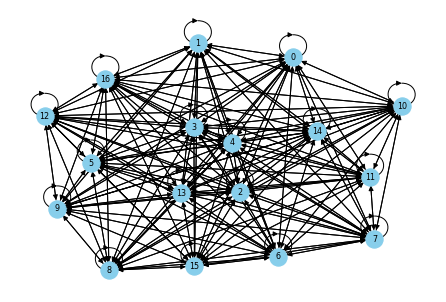

In [94]:
# Load TSP instance
problem = tsplib95.load('./ALL_atsp/br17.atsp/br17.atsp')

problem.as_name_dict()
nodes = list(problem.get_nodes())
edges = list(problem.get_edges())

w = problem.get_weight(0, 16)

# Create a NetworkX graph from the problem
graph = problem.get_graph()
weights_list = [graph.edges[edge]['weight'] for edge in graph.edges()]

print(problem.edge_weight_type)

# Create a circular layout for the nodes
pos = nx.spring_layout(graph)

# Plot the graph
nx.draw(graph, pos=pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8)

# Show the plot
plt.show()

### TSP Environment

In [95]:
class TSPEnv():
	def __init__(self, problem):
		self.problem = problem
		self.n_states = len(list(problem.get_nodes()));
		self.n_actions = self.n_states;

		self.graph = problem.get_graph();
		self.max_dist = self.n_states * max([graph.edges[edge]['weight'] for edge in graph.edges()])
		np.random.seed(0)
		self.state = np.random.randint(0, self.n_states - 1)
		self.visited_states = [self.state]
		self.unreachable_states = self.get_unreachable_states()

	def reset(self):
		self.state = np.random.randint(0, self.n_states - 1)
		self.visited_states = [self.state]
		return self.state

	def get_unreachable_states(self):
		unreachable = []
		for edge in graph.edges():
			if(graph.edges[edge]['weight'] == 0):
				# add edge to set unreachable
				unreachable.append(edge)
		return unreachable

	def initialize_Q(self):
		Q = np.zeros([self.n_states, self.n_states])
		for i in range(0, self.n_states):
			for j in range(0, self.n_states):
				Q[i][j] = self.problem.get_weight(i, j)

		return Q
	
	def reward_neg(self, state, action, next_state):
		dist = problem.get_weight(state, next_state)

		if(dist == 0):
			return 0

		return -1 * problem.get_weight(state, next_state)
	
	def reward_rec(self, state, action, next_state):
		dist = problem.get_weight(state, next_state)
		if(dist == 0):
			return 1 / 0.0001
			
		return 1 / dist

	def get_dist(self, verbose=False):
		dist = 0
		for i in range(0, self.n_states):
			dist += problem.get_weight(self.visited_states[i], self.visited_states[i + 1])

		return dist


	def step(self, action):
		next_state = action;
		
		r = self.reward_neg(self.state, action, next_state);
		self.visited_states.append(next_state);
		self.state = next_state;

		if len(self.visited_states) == self.n_states + 1:
			return next_state, r, True

		return next_state, r, False

	def render_path(self):

		# Create a list of edges in the visited path
		path_edges = [(self.visited_states[i], self.visited_states[i + 1]) for i in range(len(self.visited_states) - 1)]

		# Create a subgraph containing only the nodes and edges along the specified path
		path_graph = nx.Graph()
		path_graph.add_nodes_from(self.visited_states)
		path_graph.add_edges_from(path_edges)

		# Choose a layout algorithm (e.g., spring layout) for the subgraph
		pos = nx.kamada_kawai_layout(path_graph)

		# Plot the subgraph representing the visited path
		nx.draw(path_graph, pos=pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, edge_color='red')

### Training

##### QLearning Training -

In [96]:
def train_Q(env, agent, n_episodes):
	running_avg_window = 50  

	rewards = []
	running_avg_rewards = []  

	for episode in tqdm.tqdm(range(n_episodes)):

		state = env.reset()
		done = False
		ep_reward = 0

		while not done:
			action = agent.epsilon_greedy(state, env.visited_states)
			next_state, reward, done = env.step(action)
			agent.train(state, action, reward, next_state)
			state = next_state
			ep_reward += reward

		dist_covered = env.get_dist()
		rewards.append(dist_covered)

		if episode >= running_avg_window - 1:
			running_avg = np.mean(rewards[episode - running_avg_window + 1 : episode + 1])
			running_avg_rewards.append(running_avg)

	print("Minimum distance:", min(rewards))

	plt.figure(figsize=(15, 8))
	# plt.plot(rewards, label="Episode Reward")
	plt.plot(running_avg_rewards, label=f"Running Average ({running_avg_window} episodes)")
	plt.xlabel("Episodes")
	plt.ylabel("Distance covered in path")
	plt.legend()
	plt.show()

##### Sarsa Training

In [100]:
def train_Sarsa(env, agent, n_episodes):
	running_avg_window = 50 

	rewards = []
	running_avg_rewards = []  

	for episode in tqdm.tqdm(range(n_episodes)):

		state = env.reset()
		action = agent.epsilon_greedy(state, env.visited_states)
		done = False
		ep_reward = 0

		while not done:
			next_state, reward, done = env.step(action)
			if(done):
				break;
			next_action = agent.epsilon_greedy(state, env.visited_states)
			agent.train(state, action, reward, next_state, next_action)
			state = next_state
			action = next_action
			ep_reward += reward

		dist_covered = env.get_dist()
		rewards.append(dist_covered)

		if episode >= running_avg_window - 1:
			running_avg = np.mean(rewards[episode - running_avg_window + 1 : episode + 1])
			running_avg_rewards.append(running_avg)

	print("Minimum distance:", min(rewards))

	plt.figure(figsize=(15, 8))
	# plt.plot(rewards, label="Episode Reward")
	plt.plot(running_avg_rewards, label=f"Running Average ({running_avg_window} episodes)")
	plt.xlabel("Episodes")
	plt.ylabel("Distance covered in path")
	plt.legend()
	plt.show()

	print(rewards)
	print(running_avg_rewards)

#### DQN Training

In [ ]:
from algorithms.DQN import DQN


100%|██████████| 100/100 [00:00<00:00, 1035.97it/s]


Minimum distance: 79


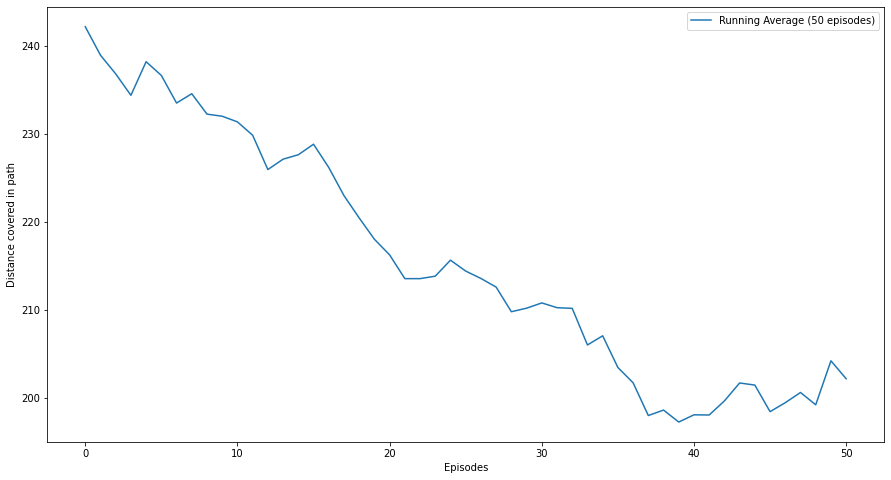

[335, 189, 224, 119, 257, 246, 311, 248, 212, 217, 161, 309, 161, 311, 330, 286, 253, 211, 287, 223, 294, 255, 217, 252, 295, 191, 344, 268, 193, 237, 149, 128, 325, 257, 259, 296, 300, 266, 160, 158, 217, 190, 184, 332, 338, 325, 128, 258, 132, 271, 173, 83, 102, 310, 179, 89, 364, 132, 200, 185, 85, 114, 220, 336, 390, 154, 93, 84, 166, 134, 159, 255, 231, 343, 233, 149, 295, 128, 213, 267, 122, 124, 117, 309, 79, 209, 114, 297, 92, 199, 216, 270, 286, 320, 187, 376, 186, 188, 382, 169]
[242.18, 238.94, 236.82, 234.38, 238.2, 236.64, 233.5, 234.56, 232.24, 232.0, 231.36, 229.84, 225.94, 227.12, 227.62, 228.82, 226.18, 222.98, 220.44, 218.02, 216.24, 213.54, 213.54, 213.82, 215.64, 214.4, 213.56, 212.58, 209.78, 210.18, 210.78, 210.24, 210.16, 206.0, 207.04, 203.44, 201.7, 197.98, 198.6, 197.24, 198.06, 198.04, 199.64, 201.68, 201.44, 198.42, 199.44, 200.6, 199.2, 204.2, 202.16]


In [101]:
from algorithms.QLearning import QAgent
from algorithms.Sarsa import SarsaAgent

env = TSPEnv(problem);

# agent = QAgent(env.n_states, env.n_actions, epsilon = 1.0, epsilon_min = 0.01, epsilon_decay = 0.999, gamma = 0.01, lr = 0.0001);
# train_Q(env, agent, n_episodes = 1000)

agent = SarsaAgent(env.n_states, env.n_actions, epsilon = 1.0, epsilon_min = 0.0001, epsilon_decay = 0.999, gamma = 0.01, lr = 0.001);
train_Sarsa(env, agent, n_episodes = 100)

Inference

Min Test Distance: 39


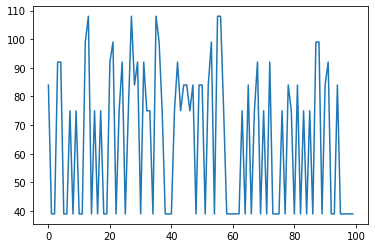

In [99]:
# agent.Q = Q

test_reward = []
for i in range(100):
	state = env.reset()
	done = False
	ep_reward = 0

	while not done:

		action = agent.greedy(state, env.visited_states)
		
		next_state, reward, done = env.step(action)

		state = next_state
		ep_reward += reward

	test_reward.append(env.get_dist(verbose=True))

plt.plot(test_reward)
print("Min Test Distance:", min(test_reward))